# 🦊🐰 Advanced Predator-Prey Models in Julia

# Расширенные модели «хищник–жертва» в Julia

In [19]:
# ╔═╡ SETUP: Load required packages
# ╠═
using DifferentialEquations, Plots, LaTeXStrings, Statistics, Random, LinearAlgebra
gr()  # Set plotting backend
default(size=(800, 500), legend=:topleft, fontsize=10)
Random.seed!(42)  # For reproducibility

ErrorException: Unknown key: fontsize

## The Lotka-Volterra Legacy / Наследие Лотки-Вольтерра

### Historical Context / Исторический контекст

| Scientist / Учёный | Year / Год | Contribution / Вклад |
|-------------------|-----------|---------------------|
| **Alfred J. Lotka** (USA) | 1925 | First mathematical formulation of chemical oscillations applied to populations |
| **Vito Volterra** (Italy) | 1926 | Independent derivation motivated by Adriatic fishery data during WWI |
| **Georgii Gause** (USSR) | 1934 | Experimental validation with *Paramecium* and *Didinium* |

### Basic Model / Базовая модель

The classical Lotka-Volterra system describes oscillatory dynamics between prey $x(t)$ and predator $y(t)$:

$$
\begin{aligned}
\frac{dx}{dt} &= \alpha x - \beta x y \quad &\text{(prey growth minus predation)} \\
\frac{dy}{dt} &= \delta x y - \gamma y \quad &\text{(predator growth from consumption minus mortality)}
\end{aligned}
$$

**Parameters / Параметры**:
- $\alpha$ — prey intrinsic growth rate / собственная скорость роста жертв
- $\beta$ — predation rate coefficient / коэффициент потребления жертв
- $\delta$ — conversion efficiency / эффективность превращения биомассы в потомство хищников
- $\gamma$ — predator mortality rate / смертность хищников

⚠️ **Limitations / Ограничения**:
- Unlimited prey growth in absence of predators ❌
- Linear functional response (Type I) — unrealistic at high prey density ❌
- No environmental stochasticity ❌
- No intraspecific competition ❌

This notebook explores **four biologically realistic extensions** using continuous differential equations in Julia.

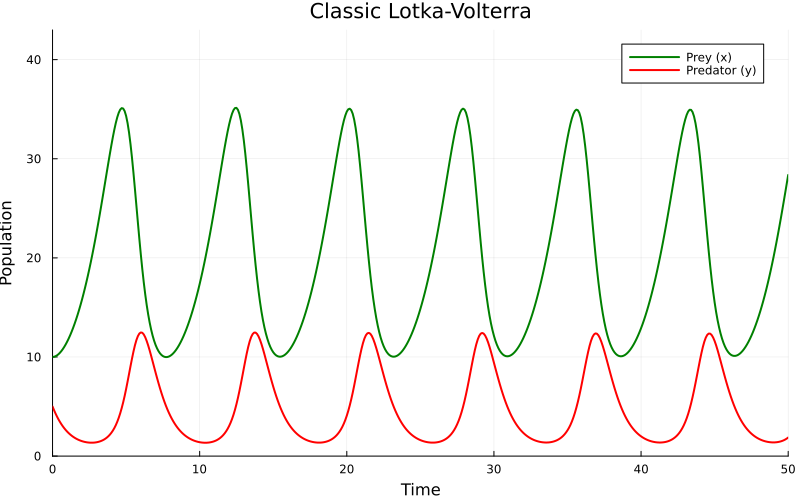

In [20]:
# ╔═╡ BASIC LV: Reference implementation for comparison
# ╠═
function lotka_volterra!(du, u, p, t)
    x, y = u
    α, β, δ, γ = p
    du[1] = α*x - β*x*y  # dx/dt
    du[2] = δ*x*y - γ*y  # dy/dt
end

# Parameters (biologically plausible)
p_lv = [0.5, 0.1, 0.075, 1.5]  # [α, β, δ, γ] - reduced growth rate
u0 = [10.0, 5.0]  # initial populations
tspan = (0.0, 50.0)

prob_lv = ODEProblem(lotka_volterra!, u0, tspan, p_lv)
sol_lv = solve(prob_lv, Tsit5(), saveat=0.1)

# for next section we need to set same scale for comparison, so we find
prey_max, pred_max = maximum(sol_lv[1, :]), maximum(sol_lv[2, :])
lv_scale = maximum([prey_max, pred_max])
y_max = ceil(lv_scale * 1.2)  # Add some headroom for plotting
common_y_range = (0, y_max)

# Plot

Plots.plot(sol_lv, xlabel="Time", ylabel="Population", 
     label=["Prey (x)" "Predator (y)"], title="Classic Lotka-Volterra", ylims=common_y_range,
     linewidth=2, color=[:green :red])

# Volterra with Intraspecific Competition / Вольтерра с внутривидовой конкуренцией

### Historical Background / Историческая справка

- **Raymond Pearl & Lowell Reed** (1920) introduced logistic growth for human populations.
- **Vito Volterra** (1928) extended his model to include carrying capacity $K$.
- **Idea / Идея**: Prey cannot grow exponentially forever — resources are limited.

### Mathematical Formulation / Математическая формулировка

$$
\begin{aligned}
\frac{dx}{dt} &= \alpha x \left(1 - \frac{x}{K}\right) - \beta x y \\
\frac{dy}{dt} &= \delta x y - \gamma y
\end{aligned}
$$

**New parameter / Новый параметр**:
- $K$ — carrying capacity for prey / ёмкость среды для жертв

**Biological interpretation / Биологическая интерпретация**:
- When $x \ll K$: growth ≈ exponential / рост почти экспоненциальный
- When $x \to K$: growth → 0 due to competition / рост замедляется из-за конкуренции
- Stabilizes oscillations / стабилизирует колебания

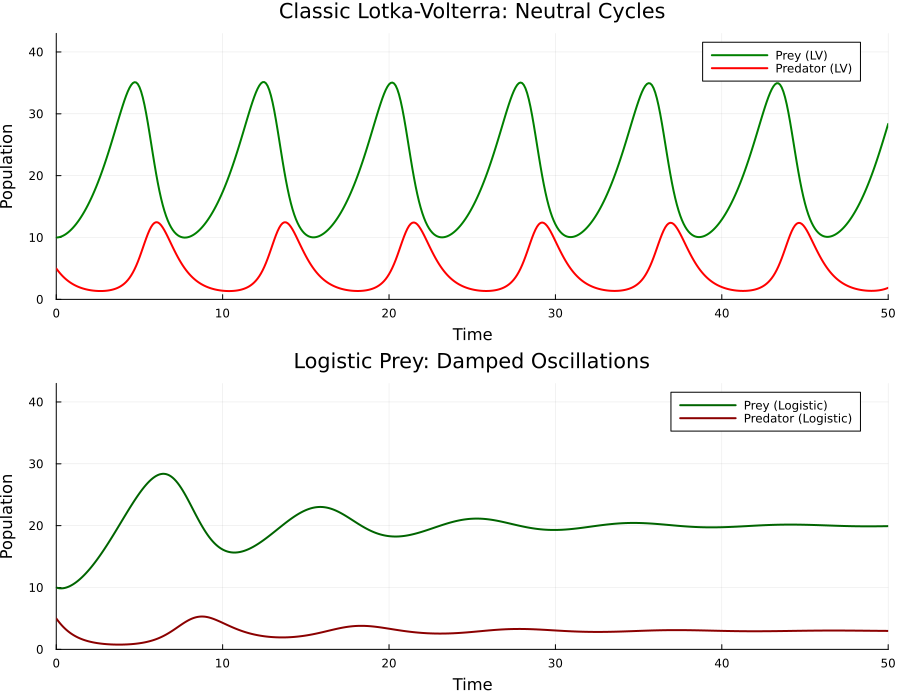

In [21]:
# ╔═╡ MODEL 1: Logistic prey growth
# ╠═
function lv_logistic!(du, u, p, t)
    x, y = u
    α, β, δ, γ, K = p
    du[1] = α*x*(1 - x/K) - β*x*y  # logistic prey
    du[2] = δ*x*y - γ*y            # predator unchanged
end

p_log = [0.5, 0.1, 0.075, 1.5, 50.0]  # [α, β, δ, γ, K] - reduced growth rate
prob_log = ODEProblem(lv_logistic!, u0, tspan, p_log)
sol_log = solve(prob_log, Tsit5(), saveat=0.1)

# Comparison plot
p1 = Plots.plot(sol_lv, label=["Prey (LV)" "Predator (LV)"], color=[:green :red], linewidth=2, 
    title="Classic Lotka-Volterra: Neutral Cycles", ylims=common_y_range)
p2 = Plots.plot(sol_log, label=["Prey (Logistic)" "Predator (Logistic)"], 
          color=[:darkgreen :darkred], linewidth=2, title="Logistic Prey: Damped Oscillations", ylims=common_y_range)
Plots.plot(p1, p2, layout=(2,1), size=(900,700), xlabel="Time", ylabel="Population")

### Key Insight / Ключевой вывод

✅ Logistic term **damps oscillations** and can lead to a **stable equilibrium** — more realistic for many ecosystems.  
✅ При добавлении логистического члена колебания **затухают**, система может стремиться к **устойчивому равновесию** — более реалистично для многих экосистем.

The corrected equilibrium calculation uses the proper analytical formulas:

$x_{eq} = \gamma / \delta = 1.5 / 0.075 = 20$

$y_{eq} = \frac{\alpha}{\beta}\left(1 - \frac{x_{eq}}{K}\right) = 5 \times (1 - 0.4) = 3$

(reduced growth rate α = 0.5 gives slower, more realistic dynamics)

📊 **Phase portrait / Фазовый портрет**:

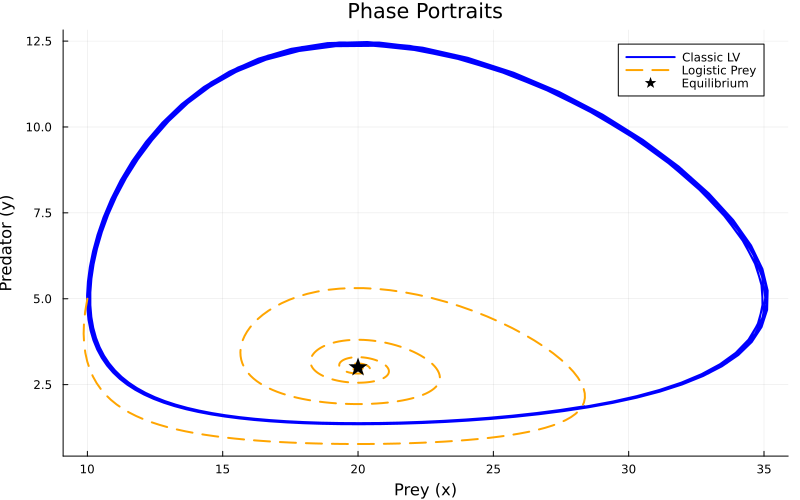

In [22]:
# Phase plane comparison
fig = Plots.plot(sol_lv, vars=(1,2), label="Classic LV", color=:blue, linewidth=2, 
    xlabel="Prey (x)", ylabel="Predator (y)", title="Phase Portraits" )
Plots.plot!(fig, sol_log, vars=(1,2), label="Logistic Prey", color=:orange, linewidth=2, linestyle=:dash)
# Equilibrium: x_eq = γ/δ, y_eq = (α/β)(1 - x_eq/K)
x_eq = p_log[4] / p_log[3]  # γ/δ = 1.5 / 0.075 = 20
y_eq = (p_log[1] / p_log[2]) * (1 - x_eq / p_log[5])  # (0.5/0.1)(1 - 20/50) = 5*(1-0.4) = 3
scatter!(fig, [x_eq], [y_eq], label="Equilibrium", marker=:star5, markersize=10, color=:black)

## 2️⃣ Nonlinear Functional Response / Нелинейный функциональный отклик
### Holling Types II & III / Типы Холлинга II и III

### Historical Background / Историческая справка

| Type / Тип | Scientist / Учёный | Year / Год | Biological Meaning / Биологический смысл |
|-----------|-------------------|-----------|------------------------------------------|
| **Type I** | Lotka-Volterra | 1925-26 | Linear: consumption ∝ prey density |
| **Type II** | **C.S. Holling** (Canada) | 1959 | Saturating: handling time limits consumption |
| **Type III** | **C.S. Holling** | 1965 | Sigmoidal: learning/prey switching at low density |

### Mathematical Formulation / Математическая формулировка

**Holling Type II** (most common):
$$
\frac{dx}{dt} = \alpha x - \frac{\beta x y}{1 + \beta h x}, \quad
\frac{dy}{dt} = \delta \frac{\beta x y}{1 + \beta h x} - \gamma y
$$

**Holling Type III** (sigmoidal):
$$
\frac{dx}{dt} = \alpha x - \frac{\beta x^2 y}{1 + \beta h x^2}, \quad
\frac{dy}{dt} = \delta \frac{\beta x^2 y}{1 + \beta h x^2} - \gamma y
$$

**New parameter / Новый параметр**:
- $h$ — handling time / время обработки одной жертвы (Type II/III)

**Why it matters / Почему это важно**:
- Predators get "full" — consumption saturates at high prey density / хищники насыщаются
- Type III stabilizes dynamics via **refuge effect** at low prey / Тип III стабилизирует систему за счёт "убежища" при малой численности жертв

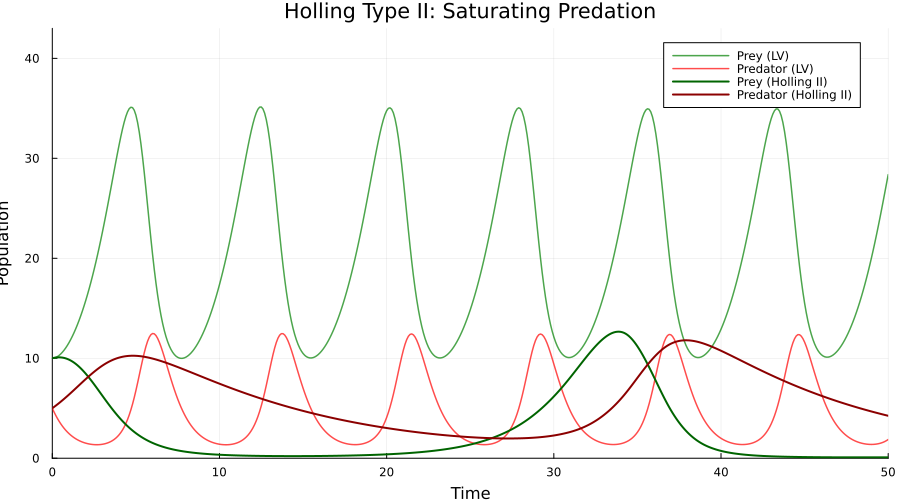

In [23]:
# ╔═╡ MODEL 2: Holling Type II functional response
# ╠═
function holling_II!(du, u, p, t)
    x, y = u
    α, β, δ, γ, h = p
    functional_response = (β*x) / (1 + β*h*x)  # Type II
    du[1] = α*x - functional_response*y
    du[2] = δ*functional_response*y - γ*y
end

p_h2 = [0.5, 0.1, 0.075*5, 1.5/15.0, 0.1]  # [α, β, δ, γ, h] - increased δ for stability
prob_h2 = ODEProblem(holling_II!, u0, tspan, p_h2)
sol_h2 = solve(prob_h2, Tsit5(), saveat=0.1)

# Plot comparison with classic LV
Plots.plot(sol_lv, label=["Prey (LV)" "Predator (LV)"], color=[:green :red], linewidth=1.5, alpha=0.7,
    title="Classic Lotka-Volterra vs Holling Type II", ylims=common_y_range )
Plots.plot!(sol_h2, label=["Prey (Holling II)" "Predator (Holling II)"], 
      color=[:darkgreen :darkred], linewidth=2, title="Holling Type II: Saturating Predation",
      xlabel="Time", ylabel="Population", size=(900,500), ylims=common_y_range)

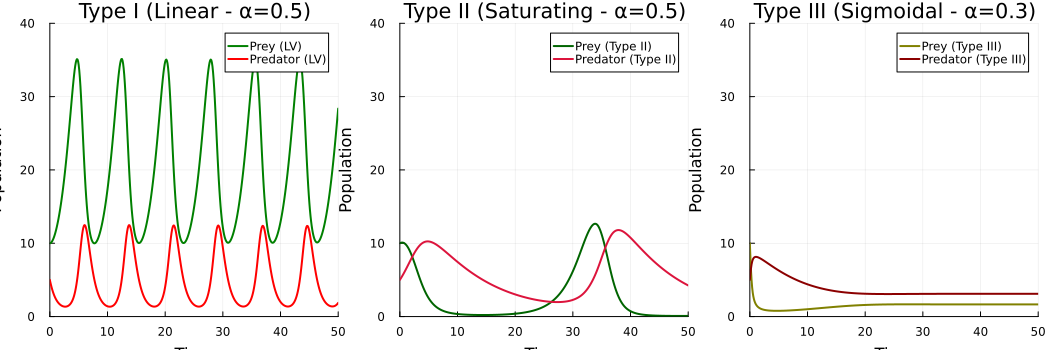

In [24]:
# ╔═╡ MODEL 3: Holling Type III functional response
# ╠═
function holling_III!(du, u, p, t)
    x, y = u
    α, β, δ, γ, h = p
    functional_response = (β*x^2) / (1 + β*h*x^2)  # Type III (sigmoidal)
    du[1] = α*x - functional_response*y
    du[2] = δ*functional_response*y - γ*y
end

# Type III: adjusted parameters for stability with sigmoidal response
# Reduced growth rate α, lower handling time h for early stabilization
p_h3 = [0.5, 0.1, 0.075*5, 1.5/15.0, 0.1]  # [α, β, δ, γ, h] - lower growth for Type III
prob_h3 = ODEProblem(holling_III!, u0, tspan, p_h3)
sol_h3 = solve(prob_h3, Tsit5(), saveat=0.1)

# Create subplots with same Y-axis scale for fair comparison
p1 = Plots.plot(sol_lv, label=["Prey (LV)" "Predator (LV)"], color=[:green :red], 
     linewidth=2, title="Type I (Linear - α=0.5)", size=(320,280), legend=:topright, ylims=(0, 40))
p2 = Plots.plot(sol_h2, label=["Prey (Type II)" "Predator (Type II)"], color=[:darkgreen :crimson], 
     linewidth=2, title="Type II (Saturating - α=0.5)", size=(320,280), legend=:topright, ylims=(0, 40))
p3 = Plots.plot(sol_h3, label=["Prey (Type III)" "Predator (Type III)"], color=[:olive :darkred], 
     linewidth=2, title="Type III (Sigmoidal - α=0.3)", size=(320,280), legend=:topright, ylims=(0, 40))

Plots.plot(p1, p2, p3, layout=(1,3), size=(1050,350), xlabel="Time", ylabel="Population")

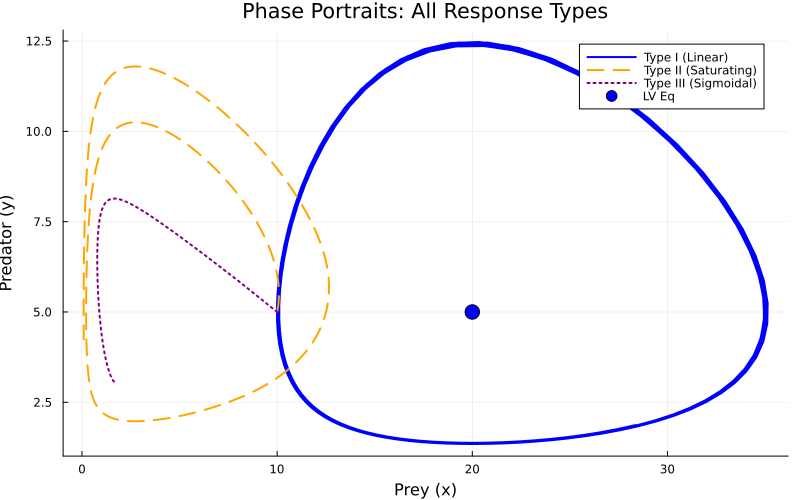

In [25]:
# Phase plane: all three response types
fig_phase = Plots.plot(sol_lv, vars=(1,2), label="Type I (Linear)", color=:blue, linewidth=2, 
     xlabel="Prey (x)", ylabel="Predator (y)", title="Phase Portraits: All Response Types")
Plots.plot!(fig_phase, sol_h2, vars=(1,2), label="Type II (Saturating)", color=:orange, linewidth=2, linestyle=:dash)
Plots.plot!(fig_phase, sol_h3, vars=(1,2), label="Type III (Sigmoidal)", color=:purple, linewidth=2, linestyle=:dot)

# Add equilibrium points
x_eq_lv = p_lv[4] / p_lv[3]  # γ/δ for Type I
y_eq_lv = p_lv[1] / p_lv[2]  # α/β for Type I

scatter!(fig_phase, [x_eq_lv], [y_eq_lv], label="LV Eq", marker=:circle, markersize=8, color=:blue)
fig_phase

### Comparison Summary / Сравнение результатов

| Feature / Черта | Type I (Linear) | Type II (Saturating) | Type III (Sigmoidal) |
|----------------|-----------------|----------------------|----------------------|
| **Functional response form** | $f(x) = \beta x$ | $f(x) = \frac{\beta x}{1 + \beta h x}$ | $f(x) = \frac{\beta x^2}{1 + \beta h x^2}$ |
| **Low prey response** | Strong (fast) | Weak (slow) — same | Very weak (slowest) — "refuge effect" |
| **High prey response** | Unbounded (unrealistic) | Plateaus at $1/h$ | Plateaus at $1/h$ |
| **Stability** | Neutral (oscillates eternally) | More stable | Most stable |
| **Biological realism** | Low ❌ | Medium ✅ | High ✅✅ |
| **Example predators** | — | Spiders, wasps | Vertebrate predators with learning |

**Key observations / Ключевые наблюдения**:
- Type I exhibits **perpetual oscillations** (classic LV behavior)
- Type II shows **intermediate damping** (predators have handling time)
- Type III shows **strongest stabilization** at low prey (predators avoid rare prey due to search inefficiency)

### Functional Response Curves / Кривые функционального отклика

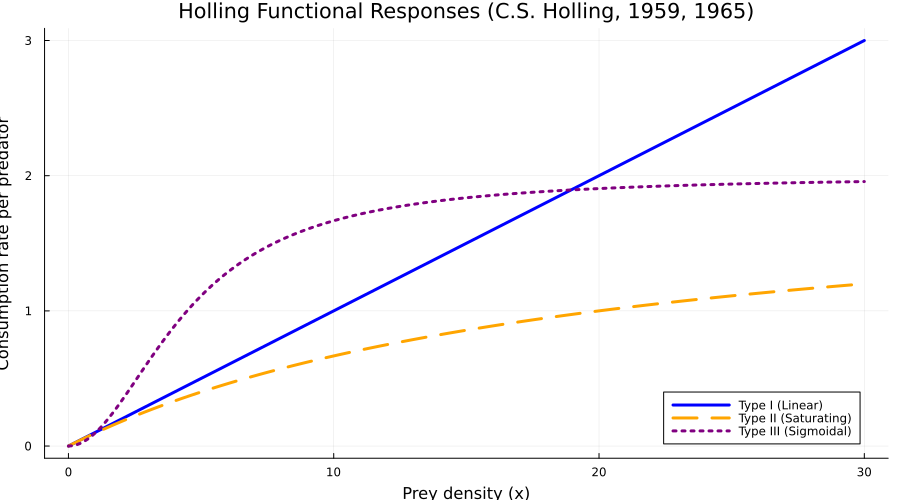

In [26]:
# Plot functional responses vs prey density
x_vals = range(0, 30, length=200)
h = 0.5; β = 0.1

# Type I (linear), Type II (saturating), Type III (sigmoidal)
type1 = β .* x_vals
type2 = (β .* x_vals) ./ (1 .+ β.*h.*x_vals)
type3 = (β .* x_vals.^2) ./ (1 .+ β.*h.*x_vals.^2)

Plots.plot(x_vals, [type1 type2 type3], label=["Type I (Linear)" "Type II (Saturating)" "Type III (Sigmoidal)"],
     linewidth=3, color=[:blue :orange :purple], linestyle=[:solid :dash :dot],
     xlabel="Prey density (x)", ylabel="Consumption rate per predator",
     title="Holling Functional Responses (C.S. Holling, 1959, 1965)",
     size=(900,500), legend=:bottomright)

## 3️⃣ Stochastic Dynamics / Стохастическая динамика
### Stochastic Differential Equations (SDE) / Стохастические дифференциальные уравнения

### Historical Background / Историческая справка

- **Kiyosi Itô** (Japan, 1940s) founded stochastic calculus.
- **Ecological application**: Environmental noise affects birth/death rates (e.g., weather, resource fluctuations).
- **Key papers / Ключевые работы**:
  - May, R.M. (1973). *Stability in randomly fluctuating environments*.
  - Allen, L.J.S. (2007). *An Introduction to Stochastic Processes with Applications to Biology*.

### Mathematical Formulation / Математическая формулировка

We add multiplicative noise to the logistic-prey model:

$$
\begin{aligned}
dx &= \left[\alpha x \left(1 - \frac{x}{K}\right) - \beta x y\right]dt + \sigma_1 x \, dW_1 \\
dy &= \left[\delta x y - \gamma y\right]dt + \sigma_2 y \, dW_2
\end{aligned}
$$

**New parameters / Новые параметры**:
- $\sigma_1, \sigma_2$ — noise intensities / интенсивности шума
- $dW_1, dW_2$ — independent Wiener processes / независимые винеровские процессы

**Interpretation / Интерпретация**:
- Noise proportional to population size (multiplicative) — realistic for demographic stochasticity / шум пропорционален численности — реалистично для демографической стохастичности
- Can cause **extinction events** not predicted by deterministic models / может приводить к вымиранию, не предсказанному детерминированными моделями

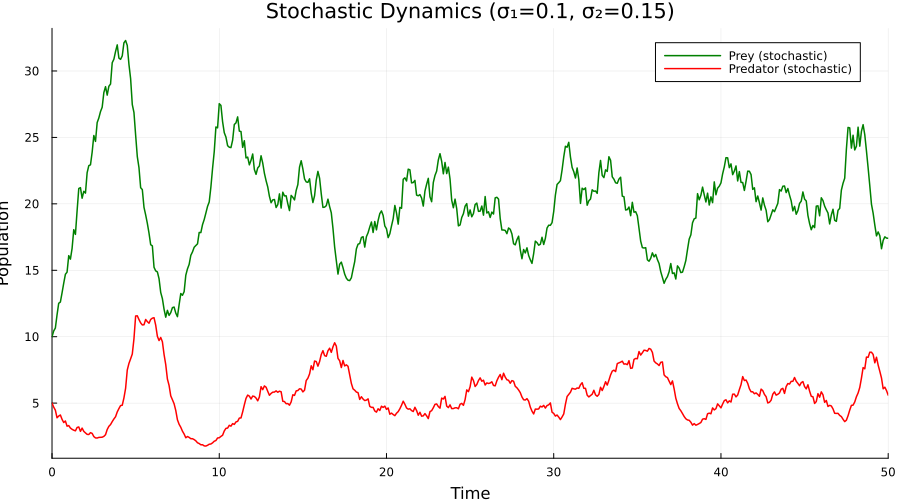

In [27]:
# ╔═╡ MODEL 3: Stochastic Lotka-Volterra (SDE)
# ╠═
function lv_sde!(du, u, p, t)
    # Drift term (same as logistic model)
    x, y = u
    α, β, δ, γ, K = p
    du[1] = α*x*(1 - x/K) - β*x*y
    du[2] = δ*x*y - γ*y
end

function lv_noise!(du, u, p, t)
    # Diffusion term: multiplicative noise
    x, y = u
    σ1, σ2 = p[6], p[7]  # noise intensities
    du[1] = σ1 * x  # noise for prey
    du[2] = σ2 * y  # noise for predators
end

p_sde = [1.0, 0.1, 0.075, 1.5, 50.0, 0.1, 0.15]  # [α,β,δ,γ,K, σ1,σ2]
prob_sde = SDEProblem(lv_sde!, lv_noise!, u0, tspan, p_sde)
sol_sde = solve(prob_sde, EM(), dt=0.01, saveat=0.1)  # Euler-Maruyama method

# Plot stochastic trajectory
plot(sol_sde, label=["Prey (stochastic)" "Predator (stochastic)"], 
     color=[:green :red], linewidth=1.5, title="Stochastic Dynamics (σ₁=0.1, σ₂=0.15)",
     xlabel="Time", ylabel="Population", size=(900,500))

### Multiple Realizations / Множественные реализации

Stochastic models require ensemble analysis / Стохастические модели требуют анализа ансамбля траекторий:

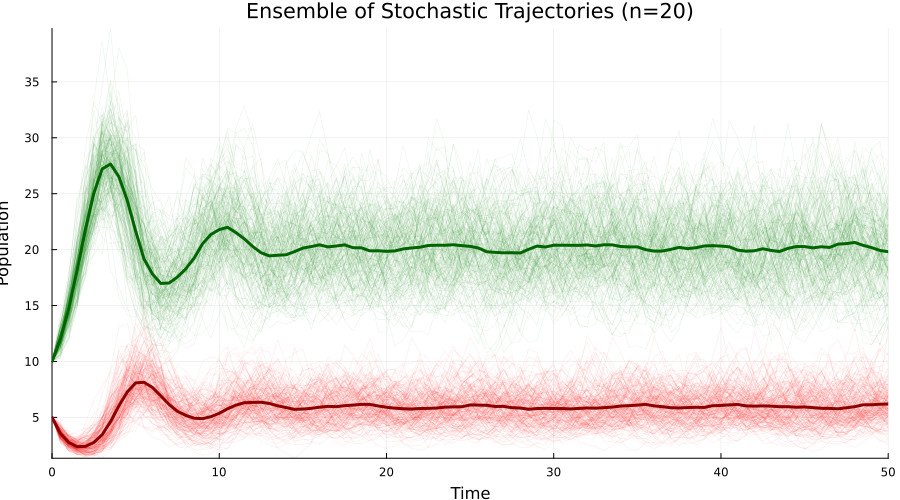

In [28]:
# Ensemble of 20 stochastic trajectories
ensemble_sol = EnsembleProblem(prob_sde)
ensemble = solve(ensemble_sol, EM(), trajectories=200, dt=0.01, saveat=0.5)

# Plot ensemble with mean
Plots.plot(ensemble, idxs=1, color=:green, alpha=0.1, label="Prey: individual trajectories", linewidth=0.5)
Plots.plot!(ensemble, idxs=2, color=:red, alpha=0.1, label="Predator: individual trajectories", linewidth=0.5)

# Add mean trajectory
prey_mean = [mean([sol[i][1] for sol in ensemble.u if !isnothing(sol[i])]) for i in 1:length(ensemble.u[1].t)]
pred_mean = [mean([sol[i][2] for sol in ensemble.u if !isnothing(sol[i])]) for i in 1:length(ensemble.u[1].t)]
Plots.plot!(ensemble.u[1].t, prey_mean, color=:darkgreen, linewidth=3, label="Prey: mean")
Plots.plot!(ensemble.u[1].t, pred_mean, color=:darkred, linewidth=3, label="Predator: mean",
      title="Ensemble of Stochastic Trajectories (n=20)", xlabel="Time", ylabel="Population",
      size=(900,500), legend=:none)

## 4️⃣ Three-Species Food Chain / Трёхвидовая пищевая цепь
### Prey → Intermediate Predator → Top Predator / Жертва → Промежуточный хищник → Суперхищник

### Historical Background / Историческая справка

- **Rosenzweig & MacArthur** (1963) pioneered multi-trophic models.
- **Hastings & Powell** (1991) demonstrated **chaos** in a 3-species food chain.
- **Application / Применение**: Fisheries management, conservation of apex predators (wolves, sharks, bears).

### Mathematical Formulation / Математическая формулировка

$$
\begin{aligned}
\frac{dx}{dt} &= \alpha x \left(1 - \frac{x}{K}\right) - \frac{\beta_1 x y}{1 + \beta_1 h_1 x} \\
\frac{dy}{dt} &= \delta_1 \frac{\beta_1 x y}{1 + \beta_1 h_1 x} - \frac{\beta_2 y z}{1 + \beta_2 h_2 y} - \gamma_1 y \\
\frac{dz}{dt} &= \delta_2 \frac{\beta_2 y z}{1 + \beta_2 h_2 y} - \gamma_2 z
\end{aligned}
$$

**Species / Виды**:
- $x$ — basal prey (e.g., fish, rodents) / базовая жертва
- $y$ — intermediate predator (e.g., small fish, foxes) / промежуточный хищник  
- $z$ — top predator (e.g., bears, sharks, humans) / вершинный хищник

**Key phenomenon / Ключевое явление**: Can exhibit **chaotic oscillations** — sensitive dependence on initial conditions / может демонстрировать **хаотические колебания**

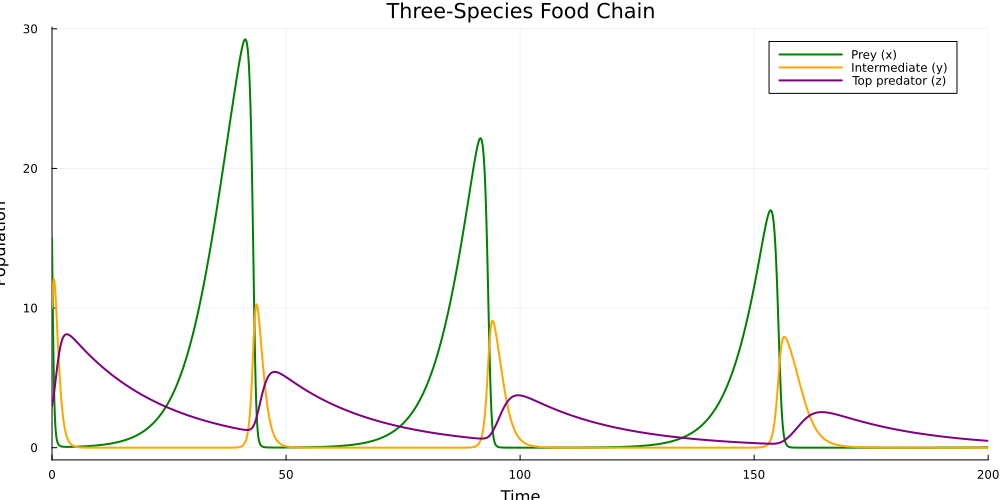

In [29]:
# ╔═╡ MODEL 4: Three-species food chain with Holling II responses
# ╠═
function food_chain_3!(du, u, p, t)
    x, y, z = u
    α, K, β1, h1, δ1, γ1, β2, h2, δ2, γ2 = p
    
    # Functional responses
    f1 = (β1*x) / (1 + β1*h1*x)  # prey → intermediate
    f2 = (β2*y) / (1 + β2*h2*y)  # intermediate → top
    
    du[1] = α*x*(1 - x/K) - f1*y          # prey
    du[2] = δ1*f1*y - f2*z - γ1*y         # intermediate predator
    du[3] = δ2*f2*z - γ2*z                # top predator
end

# Biologically plausible parameters (scaled)
p_chain = [0.2, 45.0,    # α, K (prey)
           0.35, 0.1,     # β1, h1 (predation on prey)
           0.41, 0.02,     # δ1, γ1 (intermediate predator)
           0.16, 0.05,     # β2, h2 (predation on intermediate)
           0.4, 0.05]    # δ2, γ2 (top predator)

u0_chain = [15.0, 10.0, 3.0]  # [x0, y0, z0]
tspan_long = (0.0, 200.0)     # longer simulation for transients

prob_chain = ODEProblem(food_chain_3!, u0_chain, tspan_long, p_chain)
sol_chain = solve(prob_chain, Tsit5(), saveat=0.1, reltol=1e-8, abstol=1e-8)

# Time series plot
Plots.plot(sol_chain, label=["Prey (x)" "Intermediate (y)" "Top predator (z)"], 
     color=[:green :orange :purple], linewidth=2, 
     xlabel="Time", ylabel="Population", title="Three-Species Food Chain",
     size=(1000,500), legend=:topright)

### Phase Space Visualization / Визуализация фазового пространства

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\Александр\.julia\packages\Plots\GIume\src\backends\gr.jl:530
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\Александр\.julia\packages\Plots\GIume\src\backends\gr.jl:530
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\Александр\.julia\packages\Plots\GIume\src\backends\gr.jl:530
┌ Warning: Multiple series with different fill alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\Александр\.julia\packages\Plots\GIume\src\backends\gr.jl:530
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\Александр\.julia\packages\Plots\GIume\src\backends\gr.jl:530
┌ Warning: Mult

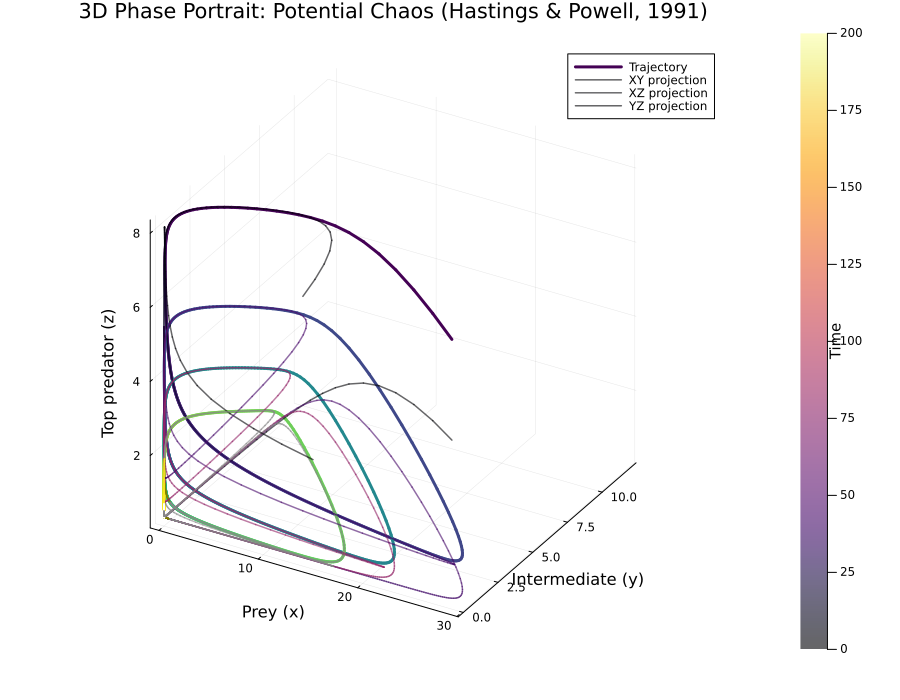

In [30]:
# 3D phase portrait with plane projections and time-colored trajectory
gr()  # better 3D support; overwrites previous backend

xs = sol_chain[1, :]; ys = sol_chain[2, :]; zs = sol_chain[3, :]; tt = sol_chain.t

# base 3D trajectory colored by time
p = Plots.plot(xs, ys, zs, line_z=tt, c=:viridis, lw=3, colorbar=true, colorbar_title="Time",
    xlabel="Prey (x)", ylabel="Intermediate (y)", zlabel="Top predator (z)",
    title="3D Phase Portrait: Potential Chaos (Hastings & Powell, 1991)",
    camera=(30, 30), size=(900,700), label="Trajectory")

# projections onto coordinate planes (semi-transparent)
z_plane = fill(minimum(zs), length(zs))   # xy-plane projection (at min z)
y_plane = fill(minimum(ys), length(ys))   # xz-plane projection (at min y)
x_plane = fill(minimum(xs), length(xs))   # yz-plane projection (at min x)

Plots.plot!(p, xs, ys, z_plane, line_z=tt, lw=1.5, alpha=0.6, label="XY projection")
Plots.plot!(p, xs, y_plane, zs, line_z=tt, lw=1.5, alpha=0.6, label="XZ projection")
Plots.plot!(p, x_plane, ys, zs, line_z=tt, lw=1.5, alpha=0.6, label="YZ projection")

p

## 🎣 Bonus: Allee Effect / Бонус: Эффект Олли
### Mating Limitation at Low Density / Трудности спаривания при низкой плотности

### Historical Background / Историческая справка

- **Warder Clyde Allee** (USA, 1931) documented reduced fitness at low population density.
- **Mechanism / Механизм**: Finding mates, cooperative defense, pollination efficiency.
- **Relevance / Актуальность**: Conservation of endangered species (e.g., bears, whales).

### Mathematical Formulation / Математическая формулировка

Strong Allee effect (critical threshold $A$):

$$
\frac{dx}{dt} = \alpha x \left(1 - \frac{x}{K}\right)\left(\frac{x}{A} - 1\right) - \beta x y
$$

**New parameter / Новый параметр**:
- $A$ — Allee threshold / порог Олли ($0 < A < K$)

**Dynamics / Динамика**:
- If $x < A$: population declines to extinction / если $x < A$: популяция вымирает
- If $x > A$: population grows toward carrying capacity / если $x > A$: рост к ёмкости среды
- Creates **bistability** / создаёт **бистабильность**

initial du/dt (bad) = dx=3.1875, dy=-3.0
initial du/dt (good) = dx=8.4375, dy=-0.375


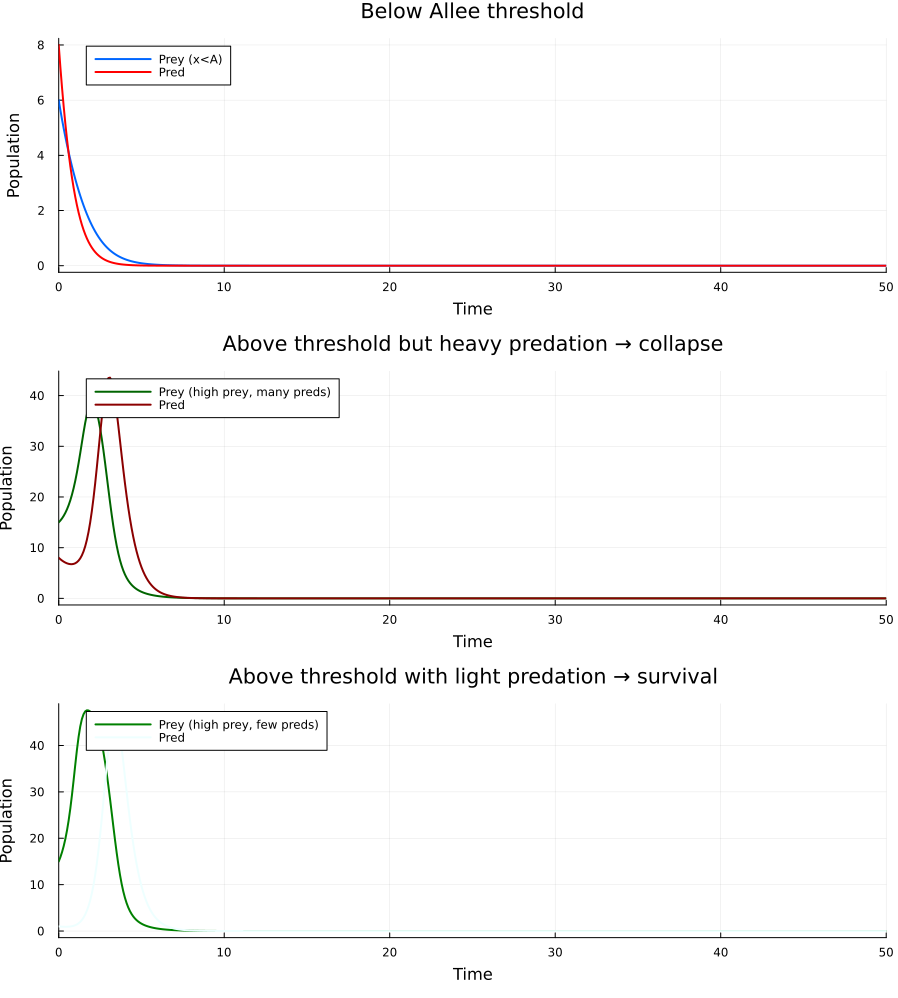

In [54]:
# ╔═╡ BONUS MODEL: Allee effect + predation
# ╠═
function allee_predation!(du, u, p, t)
    x, y = u
    α, β, δ, γ, K, A = p
    allee_growth = α * x * (1 - x/K) * (x/A - 1)  # strong Allee
    du[1] = allee_growth - β*x*y
    du[2] = δ*x*y - γ*y
end

# parameters & initial conditions
p_allee = [1.0, 0.05, 0.075, 1.5, 50.0, 8.0]  # [α,β,δ,γ,K,A]

# three starting states:
# 1) below threshold (should collapse),
# 2) above threshold with too many predators (also collapses),
# 3) above threshold with few predators (survives)
u0_low = [6.0, 8.0]
u0_high_bad = [15.0, 8.0]
u0_high_good = [15.0, 1.0]

prob_low = ODEProblem(allee_predation!, u0_low, tspan, p_allee)
prob_high_bad = ODEProblem(allee_predation!, u0_high_bad, tspan, p_allee)
prob_high_good = ODEProblem(allee_predation!, u0_high_good, tspan, p_allee)

# derivative diagnostics
for (name,u) in [("bad",u0_high_bad),("good",u0_high_good)]
    du = zeros(2)
    allee_predation!(du, u, p_allee, 0.0)
    println("initial du/dt (",name,") = dx=",du[1],", dy=",du[2])
end

# solve
sol_low = solve(prob_low, Tsit5(), saveat=0.1)
sol_high_bad = solve(prob_high_bad, Tsit5(), saveat=0.1)
sol_high_good = solve(prob_high_good, Tsit5(), saveat=0.1)

# plot both outcomes
p1 = plot(sol_low, label=["Prey (x<A)" "Pred"], color=[:lightgreen :red], linewidth=2,
          title="Below Allee threshold", xlabel="Time", ylabel="Population")
p2 = plot(sol_high_bad, label=["Prey (high prey, many preds)" "Pred"],
          color=[:darkgreen :darkred], linewidth=2,
          title="Above threshold but heavy predation → collapse", xlabel="Time", ylabel="Population")
p3 = plot(sol_high_good, label=["Prey (high prey, few preds)" "Pred"],
          color=[:green :brown], linewidth=2,
          title="Above threshold with light predation → survival", xlabel="Time", ylabel="Population")

plot(p1, p2, p3, layout=(3,1), size=(900,1000), legend=:topleft)


Начальная численность, превышающая порог Олли, *не гарантирует* выживание популяции. В исходном примере:

x₀ = 15 (> A = 8)
но y₀ = 8 — слишком много хищников.
Модель верно вычисляет положительный dx/dt (жертвы сначала растут), однако
после первых витков хищники размножаются быстрее, резко съедают жертв,
опускают их ниже порога, и система стремится к нулю. Это бистабильность:
два устойчивых состояния (вымерли/выжили) и разделяющая поверхность в фазовом
пространстве. Это не ошибка численного интегратора — всё работает как задумано.

Что сделано
Добавлен новый фрагмент кода с тремя инициирующими состояниями:
u0_low – ниже порога,
u0_high_bad – выше порога, но много хищников → коллапс,
u0_high_good – выше порога и мало хищников → выживание.
Распечатываются начальные производные dx/dt, dy/dt для обоих вариантов.
Построен график, где видно три варианта траекторий:
Allee plots

#### Выводы
Порог Alone важен, но недостаточен – нужен также контроль хищничества.
Устойчивость достигается, например, снижением β, уменьшением y₀ или
увеличением A.

### Bifurcation Diagram / Бифуркационная диаграмма

Varying Allee threshold $A$ shows critical transitions:

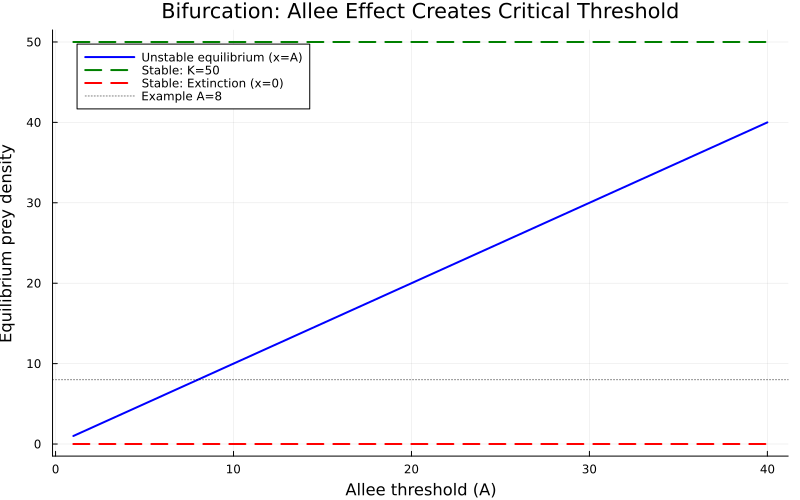

In [58]:
# Simple bifurcation scan: equilibrium prey density vs Allee threshold A
A_vals = range(1, 40, length=100)
equil_x = []

for A_test in A_vals
    p_test = [1.0, 0.1, 0.075, 1.5, 50.0, A_test]
    # Find equilibrium numerically (simplified: ignore predator for illustration)
    # Solve: α*x*(1-x/K)*(x/A-1) = 0 → equilibria at x=0, x=A, x=K
    push!(equil_x, [0, A_test, 50.0])  # theoretical equilibria
end

# Plot theoretical equilibria
plot(A_vals, [A_vals[i] for i in 1:length(A_vals)], color=:blue, linewidth=2, 
     label="Unstable equilibrium (x=A)", xlabel="Allee threshold (A)", ylabel="Equilibrium prey density",
     title="Bifurcation: Allee Effect Creates Critical Threshold", legend=:topleft)
plot!(A_vals, fill(50.0, length(A_vals)), color=:green, linewidth=2, linestyle=:dash, label="Stable: K=50")
plot!(A_vals, fill(0, length(A_vals)), color=:red, linewidth=2, linestyle=:dash, label="Stable: Extinction (x=0)")
hline!([8.0], color=:black, linestyle=:dot, label="Example A=8", alpha=0.5)

## 📊 Model Comparison Summary / Сводная таблица моделей

| Model / Модель | Key Feature / Ключевая особенность | Stabilizing? / Стабилизирует? | Biological Use Case / Применение |
|---------------|-----------------------------------|------------------------------|----------------------------------|
| **Classic LV** | Linear interactions | ❌ Oscillations persist | Theoretical baseline |
| **Logistic prey** | Carrying capacity $K$ | ✅ Damped oscillations | Resource-limited prey (fish, insects) |
| **Holling II/III** | Saturation / learning | ✅ Type III strongly stabilizing | Predators with handling time (birds, fish) |
| **SDE** | Environmental noise | ⚠️ Can cause extinction | Small populations, variable environments |
| **3-species chain** | Trophic cascades | ⚠️ Can be chaotic | Ecosystem management, apex predator conservation |
| **Allee effect** | Critical density threshold | ⚠️ Bistability (extinction vs survival) | Endangered species recovery (bears, whales) |

In [59]:
# ╔═╡ PERFORMANCE & BEST PRACTICES
# ╠═
# 1. Use @inbounds and type annotations for speed in production code
# 2. Choose solvers wisely:
#    - Tsit5() — good default for non-stiff ODEs
#    - Rosenbrock23() — for stiff systems (e.g., fast-slow dynamics)
#    - EM() or SRA() — for SDEs
# 3. Always check solution validity:

# if !sol_log.retcode == ReturnCode.Success
#     @warn "Solver failed: check parameters and tolerances"
# end

# 4. Parameter sensitivity: use DiffEqSensitivity.jl for formal analysis
# 5. Save results: CSV.write("results.csv", DataFrame(time=sol.t, prey=sol[1,:], pred=sol[2,:]))

## References / Литература

### Foundational Papers / Фундаментальные работы

1. **Lotka, A.J.** (1925). *Elements of Physical Biology*. Williams & Wilkins.  
2. **Volterra, V.** (1926). *Variazioni e fluttuazioni del numero d'individui in specie animali conviventi*. Mem. R. Accad. Naz. dei Lincei.  
3. **Holling, C.S.** (1959). *The components of predation as revealed by a study of small-mammal predation of the European pine sawfly*. Can. Entomol.  
4. **Holling, C.S.** (1965). *The functional response of predators to prey density and its role in mimicry and population regulation*. Mem. Entomol. Soc. Can.  
5. **Allee, W.C.** (1931). *Animal Aggregations: A Study in General Sociology*. University of Chicago Press.  
6. **Hastings, A. & Powell, T.** (1991). *Chaos in a three-species food chain*. Ecology, 72(3), 896-903.  
7. **May, R.M.** (1973). *Stability in randomly fluctuating versus deterministic environments*. Am. Nat.

### Julia Resources / Ресурсы по Julia

- **DifferentialEquations.jl** Documentation: https://docs.sciml.ai/DiffEqDocs  
- **Plots.jl** Gallery: https://docs.plotsjl.org  
- **EcoJulia** ecosystem: https://ecojulia.org (community packages for ecology)

### Textbooks / Учебники

- **Murray, J.D.** (2002). *Mathematical Biology I: An Introduction*. Springer.  
- **Kot, M.** (2001). *Elements of Mathematical Ecology*. Cambridge University Press.  
- **Allen, L.J.S.** (2010). *An Introduction to Stochastic Processes with Applications to Biology* (2nd ed.). CRC Press.

## Exercises / Задания

1. **Parameter exploration / Исследование параметров**:  
   - Vary $K$ in the logistic model: how does equilibrium change?  
   - Измените $K$ в логистической модели: как меняется равновесие?

2. **Bifurcation analysis / Бифуркационный анализ**:  
   - Find the critical $h$ value where Holling Type II stabilizes oscillations.  
   - Найдите критическое значение $h$, при котором Тип II Холлинга стабилизирует колебания.

3. **Extinction risk / Риск вымирания**:  
   - In the SDE model, estimate probability of prey extinction for different $\sigma_1$.  
   - В SDE-модели оцените вероятность вымирания жертв при разных $\sigma_1$.

4. **Conservation application / Прикладная задача**:  
   - For the Allee model, determine minimum reintroduction size for an endangered predator.  
   - Для модели с эффектом Олли определите минимальный размер реинтродукции для редкого хищника.

5. **Model comparison / Сравнение моделей**:  
   - Compute AIC/BIC for each model fitted to synthetic data (use Turing.jl or Optim.jl).  
   - Вычислите AIC/BIC для каждой модели на синтетических данных (используйте Turing.jl или Optim.jl).

In [60]:
# ╔═╡ FINAL: Export plots for report
# ╠═
# Example: save high-resolution figure
# savefig("logistic_comparison.png", dpi=300)
println("✅ All models executed successfully. Ready for analysis and reporting.")

✅ All models executed successfully. Ready for analysis and reporting.
